In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mean_squared_error as mse


In [147]:
train = pd.read_csv("data/RT_IOT2022.csv")
print(train.info())
print(train.describe())
train.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                123117 non-null  int64  
 1   id.orig_p                 123117 non-null  int64  
 2   id.resp_p                 123117 non-null  int64  
 3   proto                     123117 non-null  object 
 4   service                   123117 non-null  object 
 5   flow_duration             123117 non-null  float64
 6   fwd_pkts_tot              123117 non-null  int64  
 7   bwd_pkts_tot              123117 non-null  int64  
 8   fwd_data_pkts_tot         123117 non-null  int64  
 9   bwd_data_pkts_tot         123117 non-null  int64  
 10  fwd_pkts_per_sec          123117 non-null  float64
 11  bwd_pkts_per_sec          123117 non-null  float64
 12  flow_pkts_per_sec         123117 non-null  float64
 13  down_up_ratio             123117 non-null  f

Unnamed: 0  id.orig_p  id.resp_p proto service  flow_duration  \
123112        2005      59247      63331   tcp       -       0.000006   
123113        2006      59247      64623   tcp       -       0.000007   
123114        2007      59247      64680   tcp       -       0.000006   
123115        2008      59247      65000   tcp       -       0.000006   
123116        2009      59247      65129   tcp       -       0.000006   

        fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  ...  \
123112             1             1                  0                  0  ...   
123113             1             1                  0                  0  ...   
123114             1             1                  0                  0  ...   
123115             1             1                  0                  0  ...   
123116             1             1                  0                  0  ...   

        active.std  idle.min  idle.max  idle.tot  idle.avg  idle.std  \
123112         0.0       0.0       0.0       0.0       0.0       0.0   
123113         0.0       0.0       0.0       0.0       0.0       0.0   
123114         0.0       0.0       0.0       0.0       0.0       0.0   
123115         0.0       0.0       0.0       0.0       0.0       0.0   
123116         0.0       0.0       0.0       0.0       0.0       0.0   

        fwd_init_window_size  bwd_init_window_size  fwd_last_window_size  \
123112                  1024                     0                  1024   
123113                  1024                     0                  1024   
123114                  1024                     0                  1024   
123115                  1024                     0                  1024   
123116                  1024                     0                  1024   

                Attack_type  
123112  NMAP_XMAS_TREE_SCAN  
123113  NMAP_XMAS_TREE_SCAN  
123114  NMAP_XMAS_TREE_SCAN  
123115  NMAP_XMAS_TREE_SCAN  
123116  NMAP_XMAS_TREE_SCAN  

[5 rows x 85 columns]

In [148]:
train.duplicated().any()


np.False_

---
##### To-do
- class balancing (77% is DoS) - SMOTE?
- deal with outliers?


##### Done
- make a binary benign/malicious feature - benign - MQTT, Thing_speak, Wipro
- figure out what weird col is
- Show distributions - target distribustions, categorical box plot and histogram
- convert categorical
- normalization - standardScaler, min-max
- heatmap
- feature importance -> random forest feature importance, MI score, etc.


---

## Histograms

**Target**: benign -> 'MQTT_Publish, 'Thing_speak', and 'Wipro_bulb'

In [149]:
train["Attack_type"].unique()

array(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'ARP_poisioning',
       'DDOS_Slowloris', 'DOS_SYN_Hping', 'Metasploit_Brute_Force_SSH',
       'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
       'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'MQTT_Publish'),
  Text(1, 0, 'Thing_Speak'),
  Text(2, 0, 'Wipro_bulb'),
  Text(3, 0, 'ARP_poisioning'),
  Text(4, 0, 'DDOS_Slowloris'),
  Text(5, 0, 'DOS_SYN_Hping'),
  Text(6, 0, 'Metasploit_Brute_Force_SSH'),
  Text(7, 0, 'NMAP_FIN_SCAN'),
  Text(8, 0, 'NMAP_OS_DETECTION'),
  Text(9, 0, 'NMAP_TCP_scan'),
  Text(10, 0, 'NMAP_UDP_SCAN'),
  Text(11, 0, 'NMAP_XMAS_TREE_SCAN')])

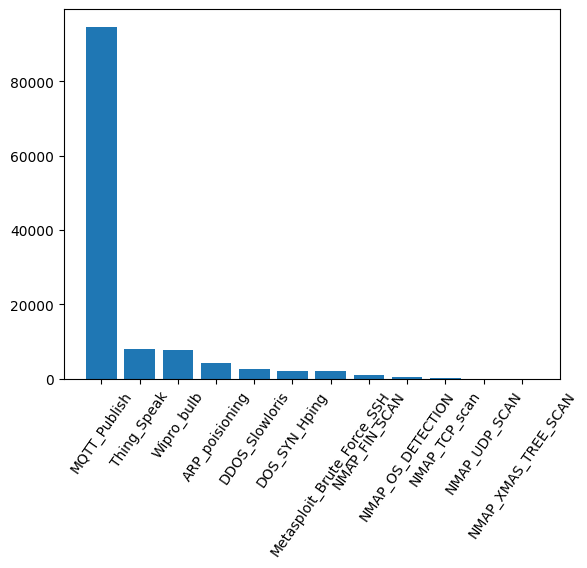

In [150]:
target = train.pop('Attack_type')
plt.bar(target.unique(), target.value_counts())
plt.xticks(rotation=55)

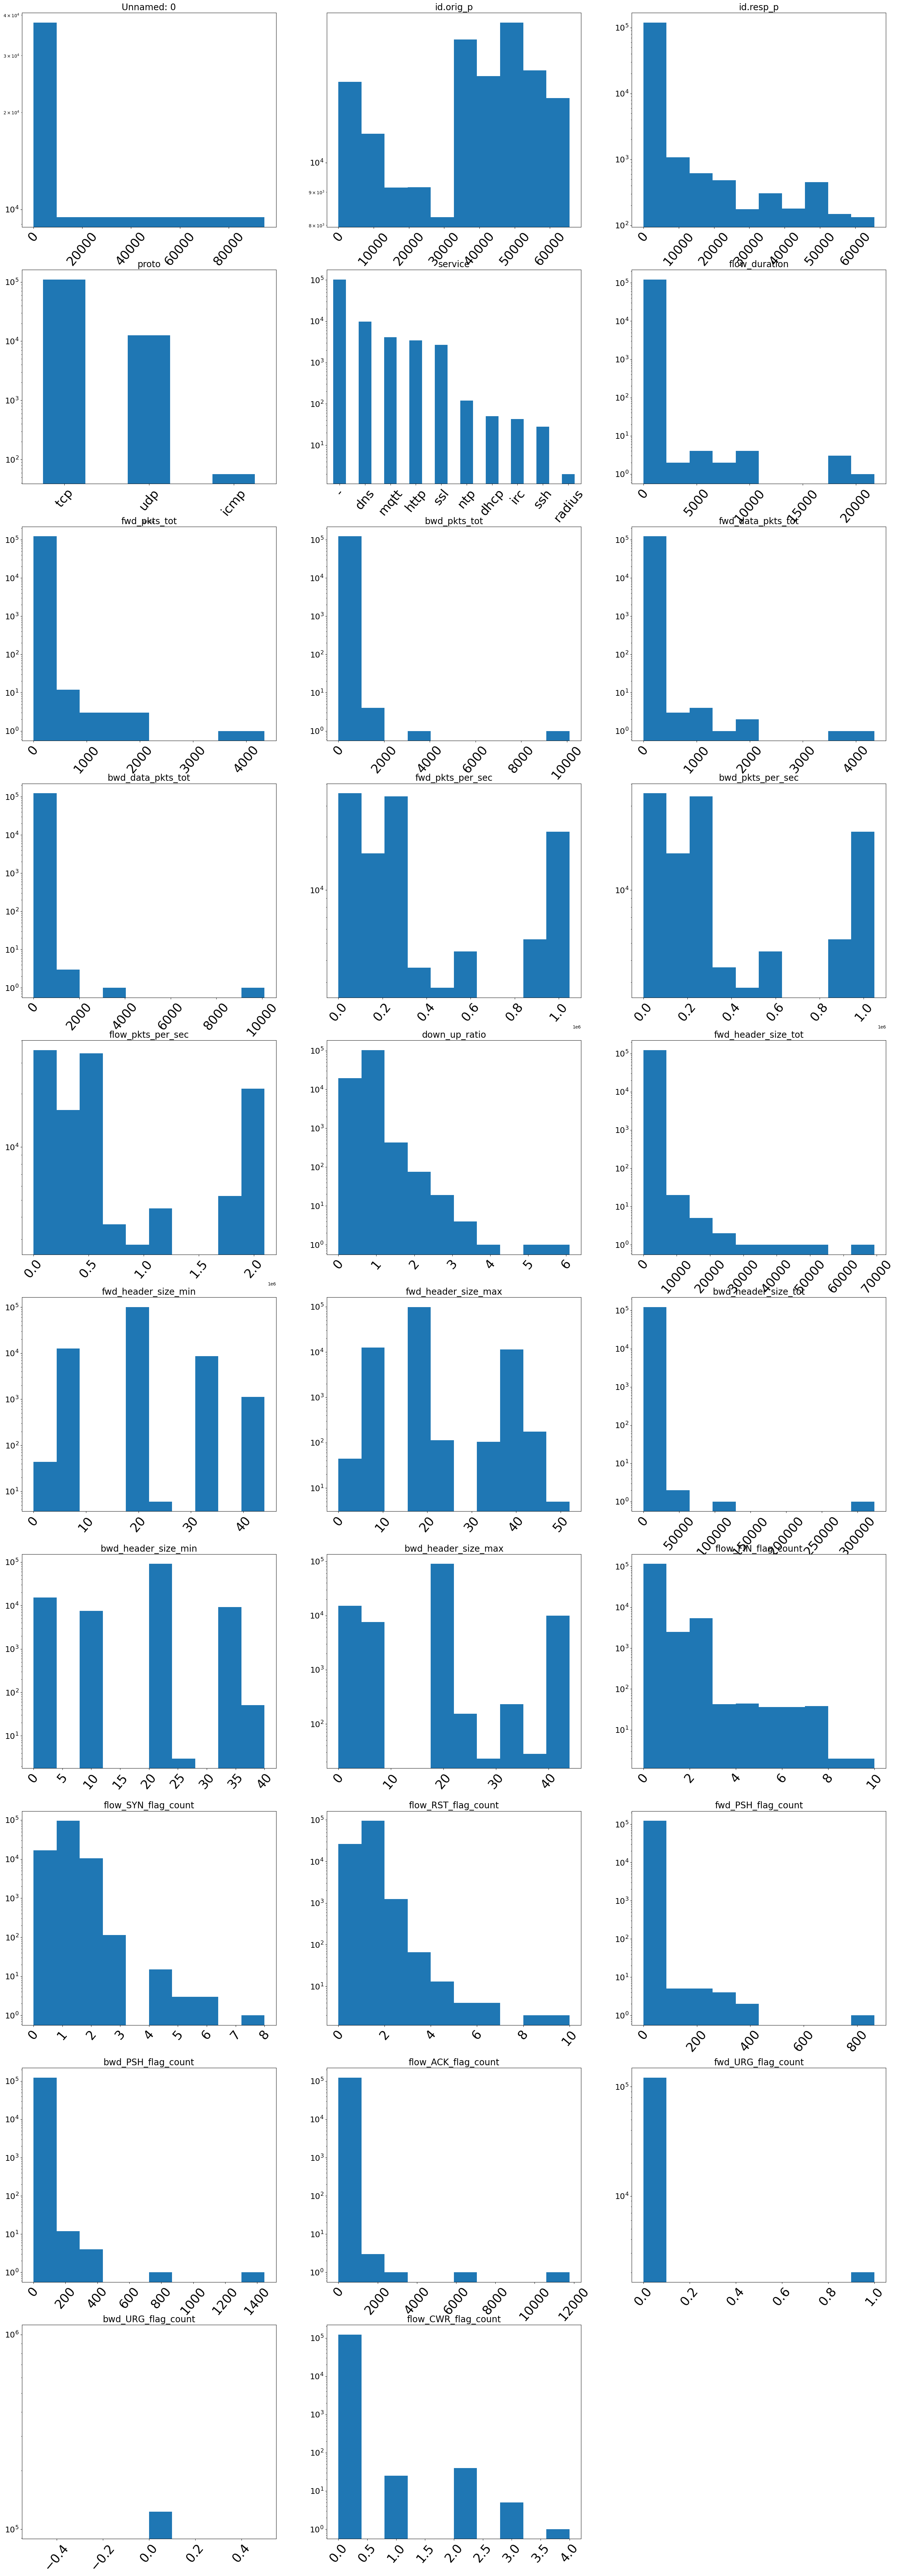

In [151]:
def visualizeHistograms(data):
    plt.figure(figsize=(35 ,230))
    for i in range(29):
        plt.subplot(11, 3, i + 1) 
        plt.subplots_adjust(bottom=.5) 
        plt.title(f"{data.columns[i]}",fontsize=20)
        if not pd.api.types.is_numeric_dtype(data.iloc[:, i]):
            data[data.columns[i]].value_counts().plot(kind='bar')
        else:
            plt.hist(train.iloc[:, i])
        
        plt.xticks(fontsize=28,rotation=50)
        plt.yticks(fontsize=18)
        plt.yscale('log') # for scaling down of outliers, i.e. makes them more visible to the eye in the graphs
    plt.show()

visualizeHistograms(train)

## Encoding

- Ordinal encoding for the service column. *note*: might switch to oneHot for this one too idk
- One hot encoding for protocol column since only 3 distinct protocols

In [152]:
train['service'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(train[['service']]).astype(int)
train['service']

0         5
1         5
2         5
3         5
4         5
         ..
123112    0
123113    0
123114    0
123115    0
123116    0
Name: service, Length: 123117, dtype: int64

In [153]:
train = pd.get_dummies(train)
train.shape

(123117, 86)

## Target Feature Engineering

- **binary_target** - if target is benign traffic then 0 else if malicious 1
- **oneHot_target** - One Hot encoded target. Therefore, there's 9 new binary columns; one for each class.
- **numberTarget** - label encoded target column. 

In [154]:
benign = ['MQTT_Publish', 'Thing_speak', 'Wipro_bulb']
binary_target = pd.DataFrame([0 if x in benign else 1 for x in target]).squeeze()

In [155]:
oneHot_target = pd.get_dummies(target, dtype=int)
oneHot_target

ARP_poisioning  DDOS_Slowloris  DOS_SYN_Hping  MQTT_Publish  \
0                    0               0              0             1   
1                    0               0              0             1   
2                    0               0              0             1   
3                    0               0              0             1   
4                    0               0              0             1   
...                ...             ...            ...           ...   
123112               0               0              0             0   
123113               0               0              0             0   
123114               0               0              0             0   
123115               0               0              0             0   
123116               0               0              0             0   

        Metasploit_Brute_Force_SSH  NMAP_FIN_SCAN  NMAP_OS_DETECTION  \
0                                0              0                  0   
1                                0              0                  0   
2                                0              0                  0   
3                                0              0                  0   
4                                0              0                  0   
...                            ...            ...                ...   
123112                           0              0                  0   
123113                           0              0                  0   
123114                           0              0                  0   
123115                           0              0                  0   
123116                           0              0                  0   

        NMAP_TCP_scan  NMAP_UDP_SCAN  NMAP_XMAS_TREE_SCAN  Thing_Speak  \
0                   0              0                    0            0   
1                   0              0                    0            0   
2                   0              0                    0            0   
3                   0              0                    0            0   
4                   0              0                    0            0   
...               ...            ...                  ...          ...   
123112              0              0                    1            0   
123113              0              0                    1            0   
123114              0              0                    1            0   
123115              0              0                    1            0   
123116              0              0                    1            0   

        Wipro_bulb  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
123112           0  
123113           0  
123114           0  
123115           0  
123116           0  

[123117 rows x 12 columns]

In [156]:
le = sklearn.preprocessing.LabelEncoder().fit(target)
le.classes_

array(['ARP_poisioning', 'DDOS_Slowloris', 'DOS_SYN_Hping',
       'MQTT_Publish', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN',
       'NMAP_OS_DETECTION', 'NMAP_TCP_scan', 'NMAP_UDP_SCAN',
       'NMAP_XMAS_TREE_SCAN', 'Thing_Speak', 'Wipro_bulb'], dtype=object)

In [157]:
numberTarget = pd.DataFrame(sklearn.preprocessing.LabelEncoder().fit_transform(target), index=target.index)
numberTarget = numberTarget.squeeze()
numberTarget.shape

(123117,)

## Feature Importance

Entire datset score - 5 folds cross validation on a random forest using either f1 score or roc_auc

In [158]:
def score_dataset(X, y): # the higher the better
    model = RandomForestClassifier(random_state=0,oob_score=True,class_weight='balanced')
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    score = cross_val_score(
        model, X, y, cv=5, scoring="f1", # can also use 'roc_auc'
    )
    return score.mean()

In [159]:
score_dataset(train, binary_target)

np.float64(0.9534305853505893)

##### MI Scores

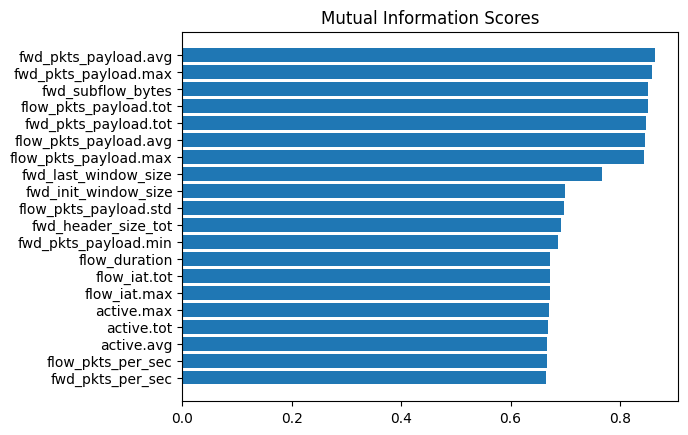

In [197]:
def makeMIscores(X, y): # this is being weird rn - saying we have a ton of target classes..
    x = X.copy()
    # dropping the port columns from score because we know this is very important alread. 
    # They are also technically discrete but have too many unique values for sklearn's MI classifier to use correctly
    x = x.drop(['id.resp_p','id.orig_p'],axis=1)
    for colname in x.select_dtypes(["object", "category"]):
        x[colname], _ = x[colname].factorize()
    for colname in x:
        x[colname] = x[colname].fillna(x[colname].max()+1) # filling with just over max value rn because only the two ratio columns have nulls atm
    # all data is in the correct format to now calculate score
    discrete_features = [x.columns.get_loc("service"),x.columns.get_loc('fwd_init_window_size'),x.columns.get_loc('bwd_init_window_size')]
    mi_scores = mutual_info_classif(x, y, discrete_features=discrete_features, random_state=1)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plotMIscores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

scores = makeMIscores(train, numberTarget)    
# plotMIscores(scores.tail(20))
plotMIscores(scores.head(20))

### Random Forest Feature Importance

In [99]:
featureTree = RandomForestClassifier(criterion='gini',class_weight='balanced')
featureTree.fit(train, binary_target)

RandomForestClassifier(class_weight='balanced')

In [100]:
x = featureTree.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': train.columns, 'Entropy': x}).sort_values('Entropy', ascending=False) 
feature_imp_df

Feature   Entropy
71           active.max  0.129611
3               service  0.090408
72           active.tot  0.082997
73           active.avg  0.064049
24  flow_ACK_flag_count  0.063502
..                  ...       ...
25   fwd_URG_flag_count  0.000004
66     fwd_bulk_packets  0.000004
28  flow_ECE_flag_count  0.000002
64       fwd_bulk_bytes  0.000001
26   bwd_URG_flag_count  0.000000

[86 rows x 2 columns]

## Heatmap


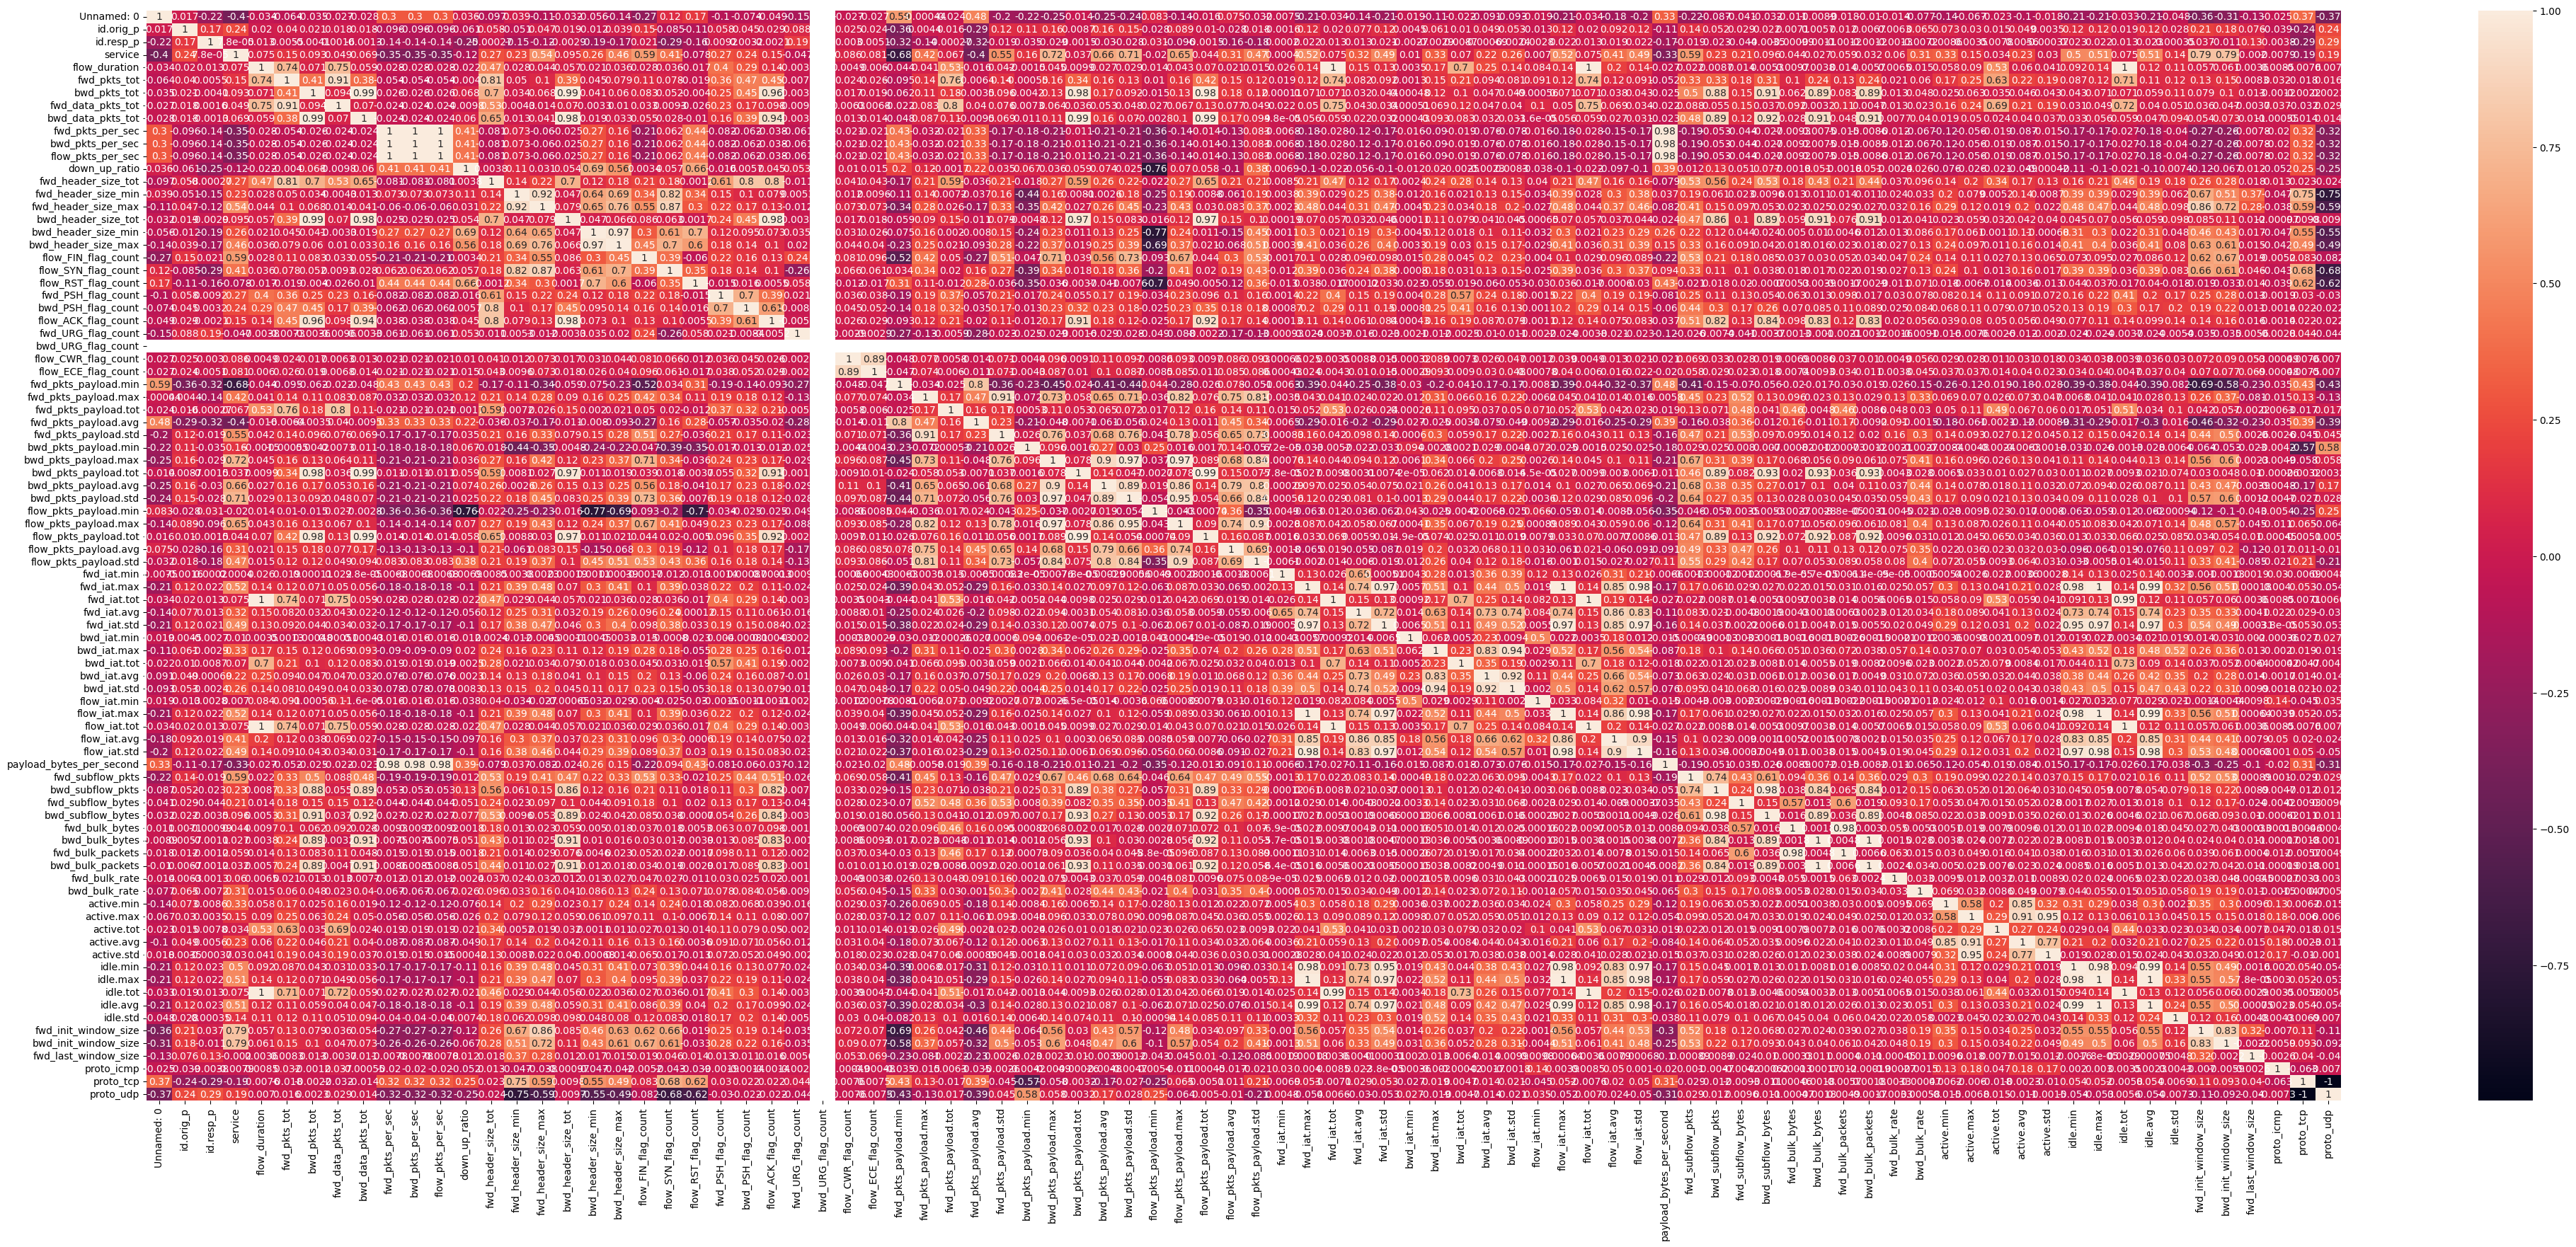

In [101]:
plt.figure(figsize=(50, 20))
sns.heatmap(train.corr(), annot=True)
plt.show()

In [102]:
def find_corrPairs(corr_matrix, threshold=.95):
    correlated_pairs = []
    # Loop through matrix and collect pairs
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                correlated_pairs.append((col1, col2, corr_matrix.iloc[i, j]))
    return pd.DataFrame(correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

pairs = find_corrPairs(train.corr().abs(), .96)

**NOTE** <br>
To see if one from these pairs need to be dropped, test on your model. <br>
For example, to see if we need all min, max, std, avg, AND totals, test with and without a combination of those and evaluate performance. Also consider feature aggregation.

In [103]:
pairs.sort_values(by='Feature 1')

Feature 1                 Feature 2  Correlation
45        bwd_bulk_bytes          bwd_bulk_packets     0.999802
8      bwd_data_pkts_tot      bwd_pkts_payload.tot     0.991961
9      bwd_data_pkts_tot     flow_pkts_payload.tot     0.992449
7      bwd_data_pkts_tot       bwd_header_size_tot     0.977200
19   bwd_header_size_min       bwd_header_size_max     0.967963
18   bwd_header_size_tot     flow_pkts_payload.tot     0.974037
16   bwd_header_size_tot       flow_ACK_flag_count     0.976784
17   bwd_header_size_tot      bwd_pkts_payload.tot     0.968662
21  bwd_pkts_payload.max     flow_pkts_payload.max     0.971904
20  bwd_pkts_payload.max      bwd_pkts_payload.std     0.973975
22  bwd_pkts_payload.tot     flow_pkts_payload.tot     0.993704
13      bwd_pkts_per_sec         flow_pkts_per_sec     0.999997
14      bwd_pkts_per_sec  payload_bytes_per_second     0.984291
5           bwd_pkts_tot      bwd_pkts_payload.tot     0.975332
4           bwd_pkts_tot       bwd_header_size_tot     0.985229
3           bwd_pkts_tot         bwd_data_pkts_tot     0.992956
6           bwd_pkts_tot     flow_pkts_payload.tot     0.983072
43      bwd_subflow_pkts         bwd_subflow_bytes     0.976306
0          flow_duration               fwd_iat.tot     0.999719
2          flow_duration                  idle.tot     0.995023
1          flow_duration              flow_iat.tot     1.000000
38          flow_iat.max                  idle.avg     0.994813
37          flow_iat.max                  idle.max     0.999748
35          flow_iat.max              flow_iat.std     0.981454
36          flow_iat.max                  idle.min     0.977718
41          flow_iat.std                  idle.max     0.981201
40          flow_iat.std                  idle.min     0.966809
42          flow_iat.std                  idle.avg     0.980043
39          flow_iat.tot                  idle.tot     0.995023
15     flow_pkts_per_sec  payload_bytes_per_second     0.984289
44        fwd_bulk_bytes          fwd_bulk_packets     0.976616
24           fwd_iat.max              flow_iat.max     0.996647
25           fwd_iat.max              flow_iat.std     0.980388
23           fwd_iat.max               fwd_iat.std     0.972222
26           fwd_iat.max                  idle.min     0.975797
27           fwd_iat.max                  idle.max     0.996389
28           fwd_iat.max                  idle.avg     0.992227
31           fwd_iat.std              flow_iat.max     0.968917
32           fwd_iat.std              flow_iat.std     0.971838
34           fwd_iat.std                  idle.avg     0.967913
33           fwd_iat.std                  idle.max     0.968691
30           fwd_iat.tot                  idle.tot     0.994715
29           fwd_iat.tot              flow_iat.tot     0.999719
12      fwd_pkts_per_sec  payload_bytes_per_second     0.984281
11      fwd_pkts_per_sec         flow_pkts_per_sec     0.999997
10      fwd_pkts_per_sec          bwd_pkts_per_sec     0.999986
48              idle.max                  idle.avg     0.995069
46              idle.min                  idle.max     0.977974
47              idle.min                  idle.avg     0.992706
49             proto_tcp                 proto_udp     0.997494

## Feature Engineering 2

created header/payload ratios and a flag for divide by 0 instances.

**NOTE**: the lines below need to be uncommented for LSTM model as it can't handle nulls. 

In [104]:
train['f_Header_b_payload_Ratio'] = train['fwd_header_size_tot'] / train['bwd_pkts_payload.tot'].replace(0, np.nan)
# train['f_Header_b_payload_Ratio'].replace(np.nan, train['f_Header_b_payload_Ratio'].max() + 1) FOR LSTM
train['b_Header_f_payload_Ratio'] = train['bwd_header_size_tot'] / train['fwd_pkts_payload.tot'].replace(0, np.nan)
# train['b_Header_f_payload_Ratio'].replace(np.nan, train['b_Header_f_payload_Ratio'].max() + 1) FOR LSTM

train["bwd_payload_zero_flg"] = (train["bwd_pkts_payload.tot"] == 0).astype(int)
train["fwd_payload_zero_flg"] = (train["bwd_pkts_payload.tot"] == 0).astype(int)
train=train

We see this was useful as the feature importance for them after creation is high and dataset score is comparable

In [105]:
featureTree.fit(train, binary_target)
x = featureTree.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': train.columns, 'Entropy': x}).sort_values('Entropy', ascending=False) 
feature_imp_df

Feature   Entropy
72           active.tot  0.129116
23   bwd_PSH_flag_count  0.090685
71           active.max  0.083434
3               service  0.081954
73           active.avg  0.055644
..                  ...       ...
76             idle.max  0.000009
64       fwd_bulk_bytes  0.000007
66     fwd_bulk_packets  0.000002
27  flow_CWR_flag_count  0.000002
26   bwd_URG_flag_count  0.000000

[90 rows x 2 columns]

In [106]:
score_dataset(train, binary_target)

np.float64(0.9352237707719597)

## Target Heatmap

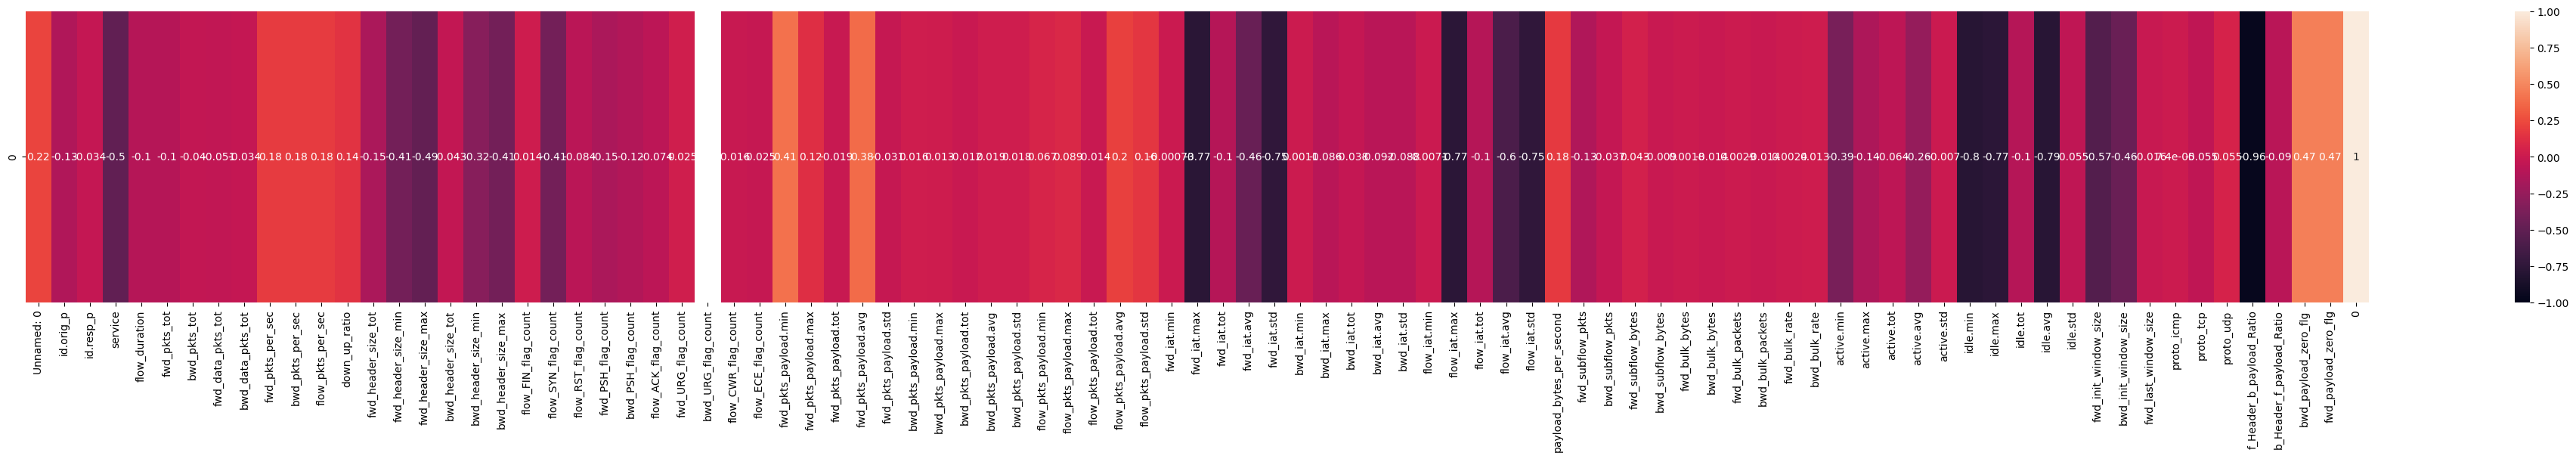

In [107]:
plt.figure(figsize=(50, 5))
sns.heatmap(pd.concat([train, binary_target], axis=1).corr().loc[[0]],
             annot=True,vmin=-1,vmax=1)
plt.show()

## Drop Columns

In [108]:
# redundant features or useless
train = train.drop(['proto_tcp','bwd_pkts_per_sec','fwd_header_size_tot','bwd_pkts_payload.tot',
                    'bwd_header_size_tot','fwd_pkts_payload.tot',"Unnamed: 0",'bwd_URG_flag_count'
                    ],axis=1)

In [109]:
score_dataset(train, binary_target)

np.float64(0.9506871006389469)

## Normalization

*Note:* Even though this is only necessary for the **Non-tree** based models (i.e. not xgboost or random forest), for consistency, all models will used the scaled data. There is no significant difference on the tree models when using scaled vs. raw data.

Used minmax scaler since all data is positive and we have outliers

In [110]:
train = pd.DataFrame(sklearn.preprocessing.MinMaxScaler().fit_transform(train), columns=train.columns, index=train.index)
train

id.orig_p  id.resp_p   service  flow_duration  fwd_pkts_tot  \
0        0.590021   0.028797  0.555556   1.473265e-03      0.002071   
1        0.780392   0.028797  0.555556   1.467374e-03      0.002071   
2        0.683009   0.028797  0.555556   1.478441e-03      0.002071   
3        0.929168   0.028797  0.555556   1.470939e-03      0.002071   
4        0.779538   0.028797  0.555556   1.468238e-03      0.002071   
...           ...        ...       ...            ...           ...   
123112   0.904051   0.968527  0.000000   2.761371e-10      0.000230   
123113   0.904051   0.988285  0.000000   3.221600e-10      0.000230   
123114   0.904051   0.989157  0.000000   2.761371e-10      0.000230   
123115   0.904051   0.994051  0.000000   2.761371e-10      0.000230   
123116   0.904051   0.996024  0.000000   2.761371e-10      0.000230   

        bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
0           0.000494            0.00069           0.000297      2.681236e-07   
1           0.000494            0.00069           0.000297      2.692003e-07   
2           0.000494            0.00069           0.000297      2.671852e-07   
3           0.000494            0.00069           0.000297      2.685480e-07   
4           0.000494            0.00069           0.000297      2.690420e-07   
...              ...                ...                ...               ...   
123112      0.000099            0.00000           0.000000      1.600000e-01   
123113      0.000099            0.00000           0.000000      1.379310e-01   
123114      0.000099            0.00000           0.000000      1.600000e-01   
123115      0.000099            0.00000           0.000000      1.600000e-01   
123116      0.000099            0.00000           0.000000      1.600000e-01   

        flow_pkts_per_sec  ...  idle.std  fwd_init_window_size  \
0            2.085404e-07  ...       0.0              0.980240   
1            2.093778e-07  ...       0.0              0.980240   
2            2.078109e-07  ...       0.0              0.980240   
3            2.088704e-07  ...       0.0              0.980240   
4            2.092547e-07  ...       0.0              0.980240   
...                   ...  ...       ...                   ...   
123112       1.600000e-01  ...       0.0              0.015625   
123113       1.379310e-01  ...       0.0              0.015625   
123114       1.600000e-01  ...       0.0              0.015625   
123115       1.600000e-01  ...       0.0              0.015625   
123116       1.600000e-01  ...       0.0              0.015625   

        bwd_init_window_size  fwd_last_window_size  proto_icmp  proto_udp  \
0                   0.409659              0.007660         0.0        0.0   
1                   0.409659              0.007660         0.0        0.0   
2                   0.409659              0.007660         0.0        0.0   
3                   0.409659              0.007660         0.0        0.0   
4                   0.409659              0.007660         0.0        0.0   
...                      ...                   ...         ...        ...   
123112              0.000000              0.015625         0.0        0.0   
123113              0.000000              0.015625         0.0        0.0   
123114              0.000000              0.015625         0.0        0.0   
123115              0.000000              0.015625         0.0        0.0   
123116              0.000000              0.015625         0.0        0.0   

        f_Header_b_payload_Ratio  b_Header_f_payload_Ratio  \
0                       0.795699                  0.001161   
1                       0.795699                  0.001161   
2                       0.848746                  0.001193   
3                       0.848746                  0.001193   
4                       0.795699                  0.001161   
...                          ...                       ...   
123112                       NaN          

## Class Balancing

In [111]:
# smote?

## Train-Test Split

In [112]:
# split

## Export Data

In [113]:
# target = target.loc[train.index]
# pd.concat([train, target], axis=1).to_csv("Data/preprocessedTrain.csv", index=False)
# test.to_csv("Data/preprocessedTest.csv", index=False)

---

### Papers to look into

- A Novel Hybrid Architecture for Superior IoT Threat Detection through Real IoT Environments - https://www.sciencedirect.com/org/science/article/pii/S1546221824007963#ref-31 
Uses dnn models like in paper 2. Uses Rt-IoT2022 dataset. Interestingly, converted this dataset back into time series data. They applied stratified sampling whcih involves dividing the data into strata based on threat types and then sampling proportionally from each stratum; useful for properly distributed train-test sets. They stacked a bunch of different NNs to leverage each of their benefits...basically made an hybrid nn model. Compared this model against commonly used ones, mainly hybrid ML. Couldn't find much on resource consumption fo this tho....seems quite costly.

- TFKAN: Transformer based on Kolmogorov–Arnold Networks for Intrusion Detection in IoT environment - https://www.sciencedirect.com/science/article/pii/S1110866525000593?ref=pdf_download&fr=RR-2&rr=985cea4b28ac64b3
Uses nn model but instead of MLP layers they used KAN. Used RT-IoT2022 dataset and 2 others. Should save on parameter number. Good related research section and end section compared against literature models. used min-max scaling.

- Expanding analytical capabilities in intrusion detection through ensemble-based multi-label classification - https://www.sciencedirect.com/science/article/pii/S0167404824000312?via%3Dihub Didn't use RT-IoT2022 dataset. used ensemble methods like in paper 1, but was ensemble nn. Multi-class detection: Interestingly, made one model for each class. Each model focuses on learning the distribution specifically related to its assigned set of labels, independent of the other label sets. Stated computational complexity didn't increase.

- PCIDS: Permission and Credibility-Based Intrusion Detection System in IoT Gateways - https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10176268  Good related research and model comparision section. Quite different than our (and other papers already gathered) approach.

- Transformer-based knowledge distillation for explainable intrusion detection system - https://www.sciencedirect.com/science/article/pii/S0167404825001063 used rt-iot2022. used min-max scaling. highlights dl resource cost. notes time series data is important. Model: a Transformer-based teacher model, which utilizes a hybrid attention mechanism combining multi-head self-attention (MHSA) and cross-attention layers. makes results interpretable.
